### Implementation

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
        
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/utils.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/framebuffer.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'
    
    
    
import random
import numpy as np
import torch
import utils


import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ENV_NAME = "MsPacman-v0"


"bash" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


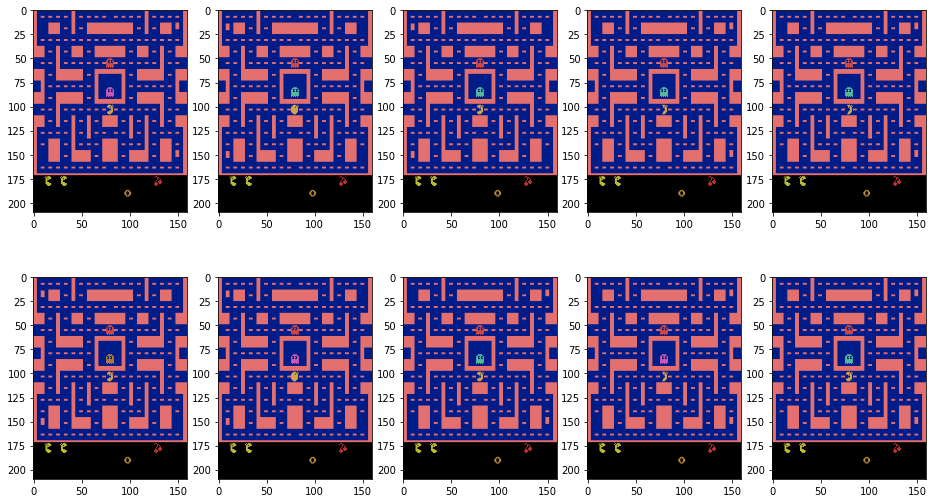

In [2]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

### Wrappers

In [3]:
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

def to_binar(a):
    if a<(70):
        return 0
    else:
        return 1
    
tobin = np.vectorize(to_binar)

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 96, 96)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return np.dot(rgb, channel_weights)


    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (Use imresize from any library you want,
        #      e.g. opencv, PIL, keras. Don't use skimage.imresize
        #      because it is extremely slow.)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type


        res=img[:175]
        res = cv2.resize(res, self.img_size[1:], interpolation = cv2.INTER_AREA)
        res= self._to_gray_scale(res)
        res=(res/255).astype('float32')
        return np.array([res])

(1, 96, 96)
Formal tests seem fine. Here's an example of what you'll get.


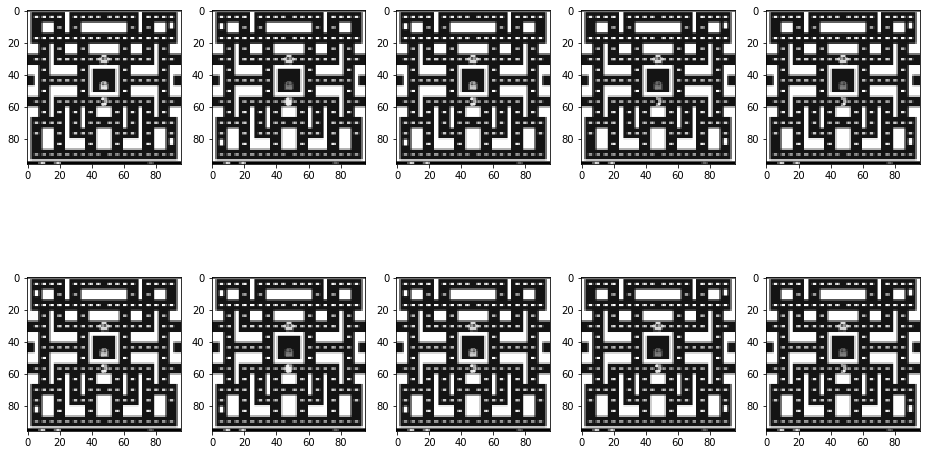

In [4]:
# spawn game instance for tests
env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())
print(obs.shape)
# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape, obs.shape
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"



print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

In [5]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

### FrameBuffer

In [6]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

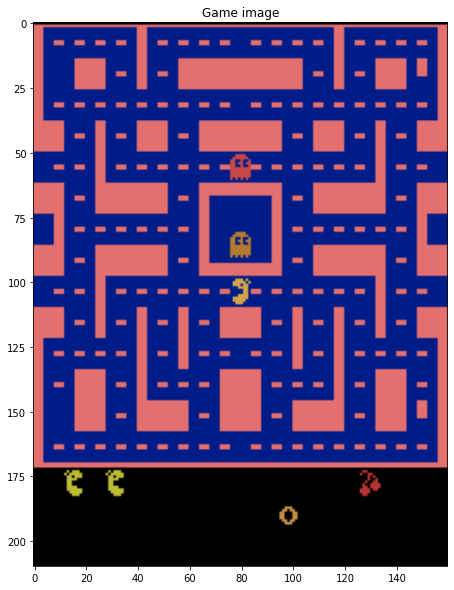

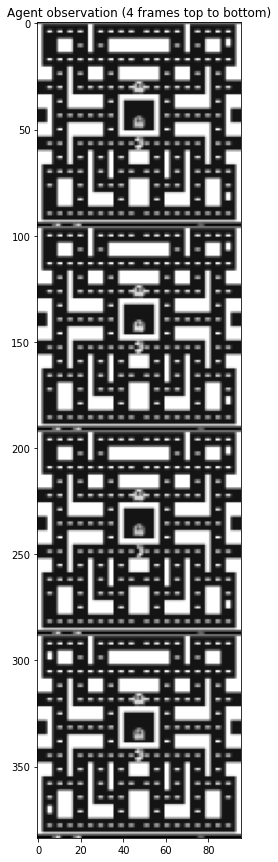

In [7]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

### DQN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [9]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [10]:
# pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(1,*obs.shape)
print(input.shape)
print(obs.shape)
print(state_shape)




class Nuer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution1 = nn.Conv2d(state_shape[0], 32, kernel_size=3)
        self.convolution2 = nn.Conv2d(32, 32, kernel_size=5)
        self.convolution3 = nn.Conv2d(32, 64, kernel_size=7)
        self.flat=nn.Flatten()
        
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 32)
        self.fc5 = nn.Linear(32, n_actions) 
   
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convolution1(x), 3))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        x = self.flat(x)
        return x

m=Nuer()

print(m(torch.tensor([obs])))
print(m(input).shape[1])

torch.Size([1, 4, 96, 96])
(4, 96, 96)
(4, 96, 96)
tensor([[0.0000, 0.0000, 0.0941, 0.1683, 0.0625, 0.0248, 0.0437, 0.0429, 0.0455,
         0.1111, 0.0511, 0.0418, 0.0325, 0.0117, 0.0401, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0564, 0.0000, 0.1376, 0.0578, 0.0000, 0.1382, 0.0000, 0.1093,
         0.0185, 0.0000, 0.0000, 0.0000, 0.0000, 0.0116, 0.0500, 0.0550, 0.0495,
         0.0548, 0.0000, 0.0000, 0.0000, 0.0000, 0.0299, 0.0000, 0.0904, 0.0839,
         0.0000, 0.0240, 0.0000, 0.0000, 0.0000, 0.0442, 0.0769, 0.0000, 0.0556,
         0.0000, 0.0000, 0.0916, 0.0620, 0.0725, 0.0000, 0.0000, 0.0638, 0.1031,
         0.0000]], grad_fn=<ReshapeAliasBackward0>)
64


C:\Users\Fyodor\AppData\Local\Temp/ipykernel_2428/1881891602.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  print(m(torch.tensor([obs])))


In [11]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        # nn.Flatten() can be useful

        '''
        self.body=nn.Sequential(
            
            nn.Conv2d(state_shape[0],16,kernel_size=3,stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            
            nn.Conv2d(16,32,kernel_size=3,stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),

            nn.Conv2d(32,64,kernel_size=3,stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),

            nn.Flatten(),
        )
        self.fc1=nn.Linear(64, 1024)
        self.fc2=nn.Linear(1024,128)
        self.fc3=nn.Linear(128, n_actions)
        
        
        
        def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues = self.body(state_t)
        qvalues = F.relu(self.fc1(qvalues))
        qvalues = F.relu(self.fc2(qvalues))
        qvalues = self.fc3(qvalues)

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and 
            qvalues.shape[0] == state_t.shape[0] and 
            qvalues.shape[1] == n_actions
        )

        return qvalues
        '''
        
        self.conv1 = nn.Conv2d(state_shape[0], 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=7)
        self.flat=nn.Flatten()
        
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 32)
        self.fc5 = nn.Linear(32, n_actions) 

    def __getOutShape__(self):
      return self.body(torch.randn(1,*state_shape,)).shape[1]

    def forward(self, x):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = F.relu(F.max_pool2d(self.conv2(x), 3))
        x = F.relu(F.max_pool2d(self.conv3(x), 3, 2))
        x = x.reshape(x.size(0), - 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x

    def get_qvalues(self, states):
        """a
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [12]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [13]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [14]:
evaluate(env, agent, n_games=1)

7.0

### Exp rep

In [15]:
from replay_buffer import ReplayBuffer, PriorReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [16]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for i in range(n_steps):
      act=agent.sample_actions(agent.get_qvalues([s]))[0]
      next_s, r, done, _ = env.step(act)
      sum_rewards +=r
      exp_replay.add(s,act,r,next_s,done)

      if done:
        next_s=env.reset()
      
      s=next_s

    return sum_rewards, s

In [17]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, \
    "play_and_record should have added exactly 1000 steps, " \
    "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, \
    "Please make sure you restart the game whenever it is 'done' and " \
    "record the is_done correctly into the buffer. Got %f is_done rate over " \
    "%i steps. [If you think it's your tough luck, just re-run the test]" % (
        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), \
        "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), \
        "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), \
        "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


### Target

In [18]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [28]:
def compute_td_loss_DQN(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device, exp_rep=None, idex=None, weights=None):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    #NOW WITH DQN!!!!
    #!
    #!
    #!
    predicted_next_agent_DQN = agent(next_states)
    maxi = torch.argmax(predicted_next_agent_DQN,axis=1).clone().detach()
    maxi = maxi[ :,None]  
    next_state_values = torch.squeeze(torch.gather(predicted_next_qvalues, 1, maxi)) 

    #next_state_values , _ = torch.max(predicted_next_qvalues, dim=1)

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards+gamma*next_state_values*is_not_done

    # mean squared error loss to minimize
    loss = ((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) )
    if exp_rep!=None:
        exp_rep.update_priorities(idex, abs(loss.data.cpu().numpy())+0.00001)
    loss=torch.mean((loss*(torch.tensor(weights)).cuda())**2)
        

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, \
            "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "there's something wrong with target q-values, they must be a vector"

    return loss






def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    #NOW WITH DQN!!!!
    #!
    #!
    #!
    '''predicted_next_agent_DQN = agent(next_states)
    maxi = torch.tensor(torch.argmax(predicted_next_agent_DQN,axis=1))
    maxi = maxi[ :,None]  
    next_state_values = torch.squeeze(torch.gather(predicted_next_qvalues, 1, maxi)) '''

    next_state_values , _ = torch.max(predicted_next_qvalues, dim=1)

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards+gamma*next_state_values*is_not_done

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, \
            "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "there's something wrong with target q-values, they must be a vector"

    return loss

In [20]:
#sanity check
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), \
    "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), \
    "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), \
    "target network should not have grads"

### Main

In [21]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

seed = 479001599
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)




In [22]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)

target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [23]:
REPLAY_BUFFER_SIZE = 40000
N_STEPS = 300

exp_replay = PriorReplayBuffer(REPLAY_BUFFER_SIZE,0.9)
for i in range(N_STEPS):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

40000


In [24]:
timesteps_per_epoch = 1
batch_size = 200
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 0.9
final_epsilon = 0.1
eps_exp=0.999998
lin_eps_threshold=100000

loss_freq = 1875
refresh_target_network_freq = 1000
eval_freq = 7500

max_grad_norm = 50

n_lives = 3
max_mean=10
max_mean_unclipped=200

In [25]:
mean_rw_history = []
mean_rw_unclipped_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [26]:
import time

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

buffer size = 40000, epsilon = 0.50994


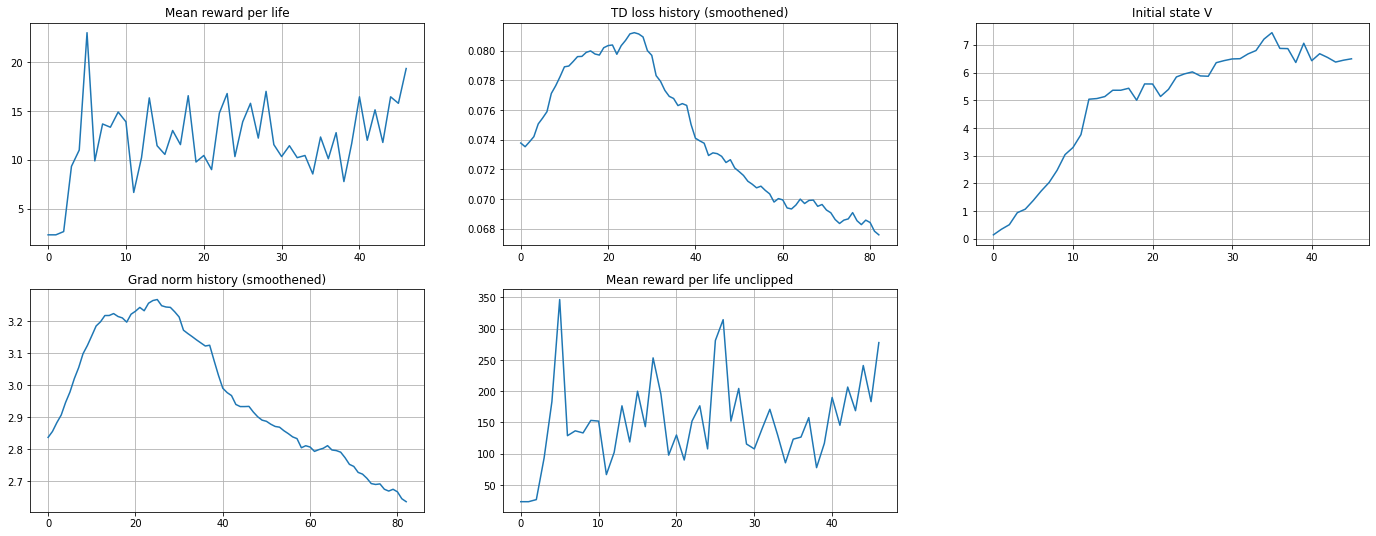

 11%|███████▌                                                           | 338108/3000001 [11:15:57<88:41:42,  8.34it/s]


KeyboardInterrupt: 

In [30]:
state = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()
        
        if step<lin_eps_threshold:
            agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
        else:
            agent.epsilon=max(eps_exp*agent.epsilon, final_epsilon)

        # play
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train
        batch, idex, weights=exp_replay.sample(batch_size,1-agent.epsilon)

        loss = compute_td_loss_DQN(*batch,agent, target_network, exp_rep=exp_replay, idex=idex,weights=weights)
        
        exp_replay.update_priorities(idex, np.full(batch_size, loss.item()))
        

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm.detach().cpu().numpy())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            torch.save(agent, 'save_state.txt')
            
            
            mean_rw_history.append(evaluate(
                make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
            )
            
            mean_rw_unclipped_history.append(evaluate(
                make_env(clip_rewards=False, seed=step), agent, n_games=3 * n_lives, greedy=True)
            )
            
            torch.save(agent, 'save_state.txt')
            if mean_rw_history[-1]>max_mean:
                torch.save(agent, 'save_max_state.txt')
                max_mean=mean_rw_history[-1]
                
            if mean_rw_unclipped_history[-1]>max_mean_unclipped:
                torch.save(agent, 'save_max_unclipped_save.txt')
                max_mean_unclipped=mean_rw_unclipped_history[-1]
            
            
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[24, 9])

            plt.subplot(2, 3, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 3, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 3, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 3, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()
            
            plt.subplot(2, 3, 5)
            plt.title("Mean reward per life unclipped")
            plt.plot(mean_rw_unclipped_history)
            plt.grid()

            plt.show()

In [34]:
agent=torch.load('save_max_state.txt')
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)


final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=90, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)

'''
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=150, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score) 
'''

final score: 575.1999999999999


"\nfinal_score = evaluate(\n  make_env(clip_rewards=False, seed=9),\n    agent, n_games=90, greedy=True, t_max=10 * 1000\n) * n_lives\nprint('final score:', final_score)\n\n\nfinal_score = evaluate(\n  make_env(clip_rewards=False, seed=9),\n    agent, n_games=150, greedy=True, t_max=10 * 1000\n) * n_lives\nprint('final score:', final_score) "

In [ ]:
gen1='no exp eps'
gen2='exp eps+saving max+saving last for backup+AdamW+more target refresh'
miss='stopped no on max'
maxn='saved max from agent_n'
gen3='no exp eps+Adam+batch=20+even more target refresh'
gen4='lin eps+Adam+0,1 wrap+larger net+larger buffer and buffer sample'
gen5='stolen from github prior exp_rep'
gen6='back to float pixels+fixed error in dqn+more sample more exp_rep'

In [ ]:
'''
def evaluate_and_show(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            env.render()
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
'''